## Optimal Taxation Simulation - Mirrlees model, Saez FOC, MWY fixed-point iteration algorithm

The code below follows Mankiw, Weinzierl, and Yagan's fixed point iteration algorithm for finding the optimal tax schedule (https://eml.berkeley.edu/~yagan/MWY_appx.pdf). That said, there are quite a few implementation differences to speed things up.

In [467]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

In [468]:
# some constants
bin = 3.50
gamma = 1.5
alpha = 2.55
sigma = 3
tol = 1e-6
scaling = 2e3

In [469]:
transfer = 0 # initially

### 1. Define the distribution and make a discretized version


We use a log normal distributio like the authors do with $\mu = 2.757$ and $\sigma = 0.5611$, though we do not have an atom at $0.01$ for simplicity.

In [470]:
normal = norm(loc=2.757, scale=0.5611)

# exp^{normal} is log normal with the desired parameters 

wages = [0.01 + bin * i for i in range(0, 144)] # synnonymous with ability, for now

pmf = []

for wage in wages:
    bin_lower = np.log(max(0.01, wage - bin/2))
    bin_upper = np.log(wage + bin/2)
    pmf.append(normal.cdf(bin_upper) - normal.cdf(bin_lower))


In [471]:
pmf = np.array(pmf)
pmf = 1/(np.sum(pmf)) * pmf

Note that the actual wage ranges from $0$ to $w_N + \Delta/2$.

In [472]:
cdf = [pmf[0]/2]
for (idx, mass) in enumerate(pmf[1:]):
    cdf.append((cdf[-1] + pmf[idx - 1]/2 + mass/2))

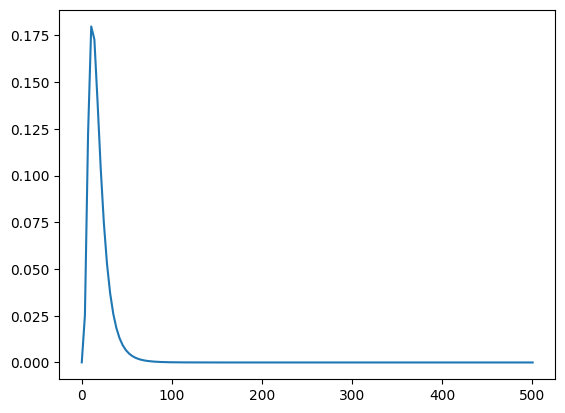

In [473]:
plt.plot(wages, pmf)

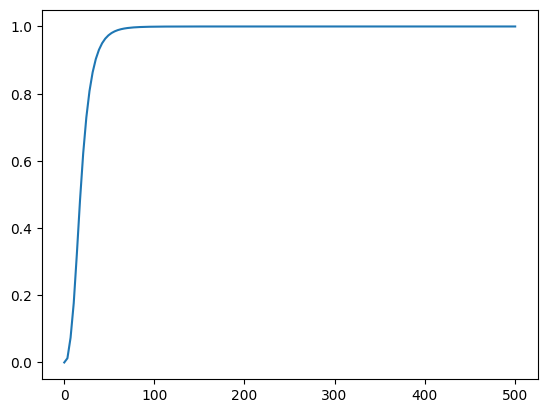

In [474]:
plt.plot(wages, cdf)

We have made the actual wage paid out to the agents the numerare in this model. The term wage and ability is used interchangeably.

### 2. Define agents

In [475]:
# TODO: check the condition for Walrus's Law holds

In [476]:
class Agent:

    def __init__(self, wage):

        # note that this is a separating equilibrium, so higher ability workers always work more 
        # okay to assume the relative ordering stays the same over time

        self.wage = wage
        self.bracket = int((wage - 0.01) / bin + 1) # 1 indexed
        self.ls = (alpha/((0.65 * self.wage)**(1 - gamma)))**(1/(1 - gamma - sigma)) # the guessed labor supply assuming a flat rate of 0.35
        self.dudc = None # u'(c(theta))
        self.consumption = None
        self.taxpaid = None

    def taxes(self, tax_schedule, earnings):
        '''
        When it comes to the i^{th} agent, the previous agents' earnings would have been calculated

        Incomes above the previous cutoff (earings of the agent in the bracket before) is taxed at the marginal rate of the previous bracket
        '''

        total_tax = 0 # cumulative tax burden
        prev_cutoff = tax_schedule[0][0]
        last_rate = tax_schedule[0][1]

        for i in range(self.bracket - 1):

            cutoff, rate = tax_schedule[i]
            
            if earnings < cutoff:
                break

            total_tax += rate * (cutoff - prev_cutoff)
            prev_cutoff = cutoff
            last_rate = rate

        total_tax += (earnings - max(prev_cutoff, 0)) * last_rate

        return total_tax
    
    def max_util(self, transfer, tax_schedule):
        '''
        utility maximization assuming walrus's law holds (no extra budget)

        transfer is from the government.
        wage is the numerare omitted.
        tax schedule: an array specifying marginal taxes at each wage/ability bin
        starting point: starting point of the search; set to None if this is the first time; otherwise, use the previous labor supply

        wage (ability) * l - T(wage (ability) * l) + transfer
        '''
        
        # cannot work negative hours
        # negative of the utility function since the routine minimizes instead of optimizes
        
        neg_utility_func = lambda l: -1 * ((self.wage*l - self.taxes(tax_schedule, self.wage*l) + transfer)**(1 - gamma) - 1)/(1 - gamma) + alpha*(l**(sigma)) / sigma if l >= 0 else 1e9
        result = minimize(neg_utility_func, self.ls)

        self.ls = result.x[0] # new optimal labor supply
        self.taxpaid = self.taxes(tax_schedule, self.wage*self.ls)
        self.consumption = self.wage*self.ls - self.taxpaid + transfer
        self.dudc = (self.wage*self.ls - self.taxes(tax_schedule, self.wage*self.ls) + transfer)**(-1 * gamma) # should do numerical differentiation for general utility functions

        return self.ls*self.wage # pre-tax earnings this turn

### 3. Iterating to find the fixed point

#### 3.1 - Calculate the new tax schedule

In [477]:
# initially - initialize the economy - flat tax schedule
agents = []
tax_schedule = [(0, 0.35)]
for wage in wages:
    agent = Agent(wage)
    optimal_wage = agent.max_util(transfer, tax_schedule)
    tax_schedule.append((optimal_wage, 0.35))
    agents.append(agent)
tax_schedule.pop(0)

(0, 0.35)

#### Update rule:

Planner's FOC, discretized:

$$\frac{T'(z)}{(1 - T'(z))} = \frac{1 + \epsilon^u(w)}{\epsilon^c(w)}\frac{u'(c(w))}{w\pi(w)/\Delta}\bigg[\sum_{w_i = w + 1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))} - (1 - \Pi(w_i)) \sum_{w_i = w_1}^{w_N} \frac{\pi(w_i)}{u'(c(w_i))}\bigg]$$

In [478]:
iterations = 0

while True:

    print(iterations, end = " ")

    revenue_check = True # if the new tansfer is within 1e-6 of the prev
    derivative_check = True # if marginal taxes are not updated by more than 1e-6

    # components of RHS
    cum_sum = [pmf[0]/agents[0].dudc]
    for (idx, agent) in enumerate(agents[1:]):
        cum_sum.append(cum_sum[-1] + pmf[idx]/agent.dudc)

    for (index, agent) in enumerate(agents):

        # calculate the new tax rate:
        e_c = 1/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # compensated elasticity
        e_u = (1 - alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1)))/(sigma - 1 + alpha * gamma * (agent.ls**sigma) * (agent.consumption ** (gamma - 1))) # uncompensated elasticity
        middle_term = agent.dudc/(wages[index] * pmf[index] / bin)
        right_term = (cum_sum[-1] - cum_sum[index]) - (1 - cdf[index]) * cum_sum[-1]
        rhs = (1 + e_u)/e_c * middle_term * right_term
        new_rate = rhs / (1 + rhs)

        # find the new schedule
        if abs(new_rate - tax_schedule[index][1]) > tol:
            derivative_check = False
        
        tax_schedule[index] = (tax_schedule[index][0], new_rate)

    # find the government revenue under this new schedule
    revenue = 0
    for (index, agent) in enumerate(agents):
        pre_tax_earning = agent.max_util(transfer, tax_schedule)
        revenue += agent.taxpaid * pmf[index]
        tax_schedule[index] = (pre_tax_earning, tax_schedule[index][1])

    if abs(transfer - revenue) > tol:
        revenue_check = False

    transfer = revenue
     
    if revenue_check and derivative_check:
        break

    for (index, agent) in enumerate(agents):
        pre_tax_earning = agent.max_util(transfer, tax_schedule) # now again with the new transfer
        tax_schedule[index] = (pre_tax_earning, tax_schedule[index][1])

    iterations += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 

### Visuals:

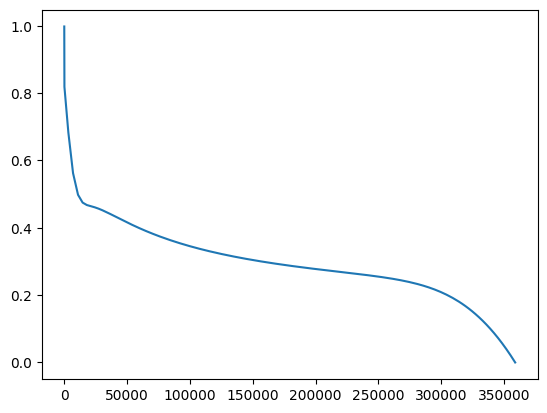

In [479]:
changes = []
rate = []

for point in tax_schedule:
    changes.append(point[0] * 2e3)
    rate.append(point[1])

plt.plot(changes, rate)